### Switching probability in first 100 trials
- Unstructured sessions showed higher alpha_chosen and lower alpha_perseverance compared to structured sessions, suggesting animals are more likely to switch in the unstructured sessions.

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.analyses import SwitchProb2Arm

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    switch_prob = SwitchProb2Arm(task).by_session()
    print(f"Switch prob: {switch_prob}")

    df = pd.DataFrame(
        {
            "switch_prob": [switch_prob],
            "name": exp.sub_name,
            "grp": exp.group_tag,
            # "first_experience": True if "Exp1" in exp.sub_name else False,
        }
    )

    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "swp_100trials")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
from mab_colors import colors_2arm
import numpy as np
from statannotations.Annotator import Annotator
from statplot_utils import stat_kw

fig = plotting.Fig(1, 4, size=(11, 3), num=1, fontsize=10)

grpdata = mab_subjects.GroupData()
df = grpdata.switch_prob_100trials
# df = df[df["first_experience"] == True]

ax = fig.subplot(fig.gs[0])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)

plot_kw = dict(data=df, x="grp", y="switch_prob", hue="grp", ax=ax)
sns.stripplot(
    palette=["gray", "gray"],
    edgecolor="white",
    # facecolor=(0, 0, 0, 0),
    # alpha=0.4,
    # errorbar="se",
    **plot_kw,
)
sns.barplot(
    palette=colors_2arm(),
    # edgecolor="0.5",
    # facecolor=(0, 0, 0, 0),
    alpha=0.6,
    errorbar="se",
    **plot_kw,
)


orders = ["unstruc", "struc"]
pairs = [(("unstruc"), ("struc"))]
annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
annotator.configure(test="Kruskal", **stat_kw, color="k", verbose=True)
annotator.apply_and_annotate()
annotator.reset_configuration()

ax.set_title("Switch probability")
# ax.legend("")

### Binned switch probability

switch probability in 0-25, 25-50, 50-75,75-100 trials

In [1]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.analyses import SwitchProb2Arm

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    swp_0to25 = SwitchProb2Arm(task.trial_slice(0, 25)).by_session()
    swp_25to50 = SwitchProb2Arm(task.trial_slice(25, 50)).by_session()
    swp_50to75 = SwitchProb2Arm(task.trial_slice(50, 75)).by_session()
    swp_75to100 = SwitchProb2Arm(task.trial_slice(75, 100)).by_session()

    switch_prob = SwitchProb2Arm(task).by_session()
    print(f"Switch prob: {switch_prob}")

    df = pd.DataFrame(
        {
            "Trials": ["0-25", "25-50", "50-75", "75-100"],
            "swp": [swp_0to25, swp_25to50, swp_50to75, swp_75to100],
            "grp": exp.group_tag,
        }
    )

    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "swp_by_quartiles")

BGM0
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Switch prob: 0.02319923707206944
BGF1
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Switch prob: 0.017602056063594527
BGF2
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Switch prob: 0.025309700781398894
BGF3
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating switch probability for all sessions
Calculating swi

'swp_by_quartiles_20260211_153517.npy'

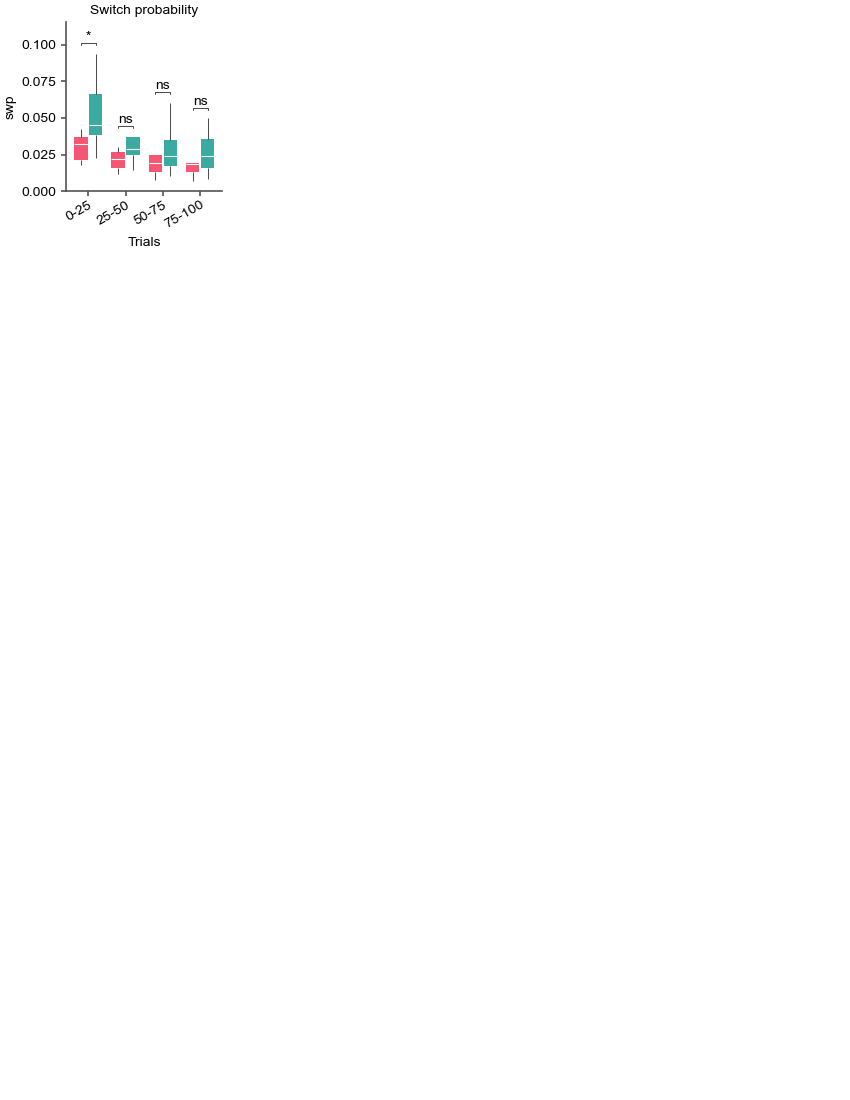

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
from mab_colors import Palette2Arm
from statplotannot.plots import Fig, SeabornPlotter
from statplotannot.plots.plot_utils import xtick_format


df = mab_subjects.GroupData().swp_by_quartiles.latest
palette = Palette2Arm(lightness_scale=1).as_dict()

fig = Fig(6, 5, fontsize=10)

ax = fig.subplot(fig.gs[0])

plot_kw = dict(
    data=df, x="Trials", y="swp", hue="grp", hue_order=["unstruc", "struc"], ax=ax
)
plotter = (
    SeabornPlotter(**plot_kw)
    .boxplot_filled(palette=palette)
    .stat_test(test_name="Kruskal")
)


ax.set_title("Switch probability")
ax.legend_.remove()
xtick_format(ax, rotation=30)
figpath = mab_subjects.figpath / "npdf"
fig.savefig(figpath / "mab_switching_probability_by_quartiles.pdf")

### Switching probability as a function of trials within session
- Check if switch probability curves for unstructured and structured sessions have same decay and tail

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from scipy.ndimage import gaussian_filter1d
from banditpy.analyses import SwitchProb2Arm


exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    task.auto_block_window_ids()

    mask1 = task.block_ids == 1
    mask2 = task.block_ids == 2
    mask3 = task.block_ids == 3

    task1 = task._filtered(mask1)
    task2 = task._filtered(mask2)
    # task3 = task._filtered(mask3)

    switch_prob1 = SwitchProb2Arm(task1).by_trial()
    switch_prob2 = SwitchProb2Arm(task2).by_trial()
    # switch_prob3 = SwitchProb2Arm(task3).by_trial()
    # switch_prob_smooth = gaussian_filter1d(switch_prob, sigma=1)

    df = pd.DataFrame(
        {
            "trial_id": np.arange(len(switch_prob1)) + 1,
            "switch_prob_block1": switch_prob1,
            "switch_prob_block2": switch_prob2,
            # "switch_prob_block3": switch_prob3,
            "name": exp.sub_name,
            # "grp": "struc" if task.is_structured else "unstruc",
            "grp": exp.group_tag,
        }
    )

    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "switch_prob_by_trial_100trials")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statannotations.Annotator import Annotator
from statplot_utils import stat_kw
from mab_colors import colors_2arm

fig = plotting.Fig(4, 2, size=(8.5, 11), num=1, fontsize=10)

grpdata = mab_subjects.GroupData()
df = grpdata.switch_prob_by_trial_100trials
# df = df[df["first_experience"] == True]

ax = fig.subplot(fig.gs[0])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)

plot_kw = dict(
    data=df,
    x="trial_id",
    y="switch_prob_block2",
    hue="grp",
    hue_order=["unstruc", "struc"],
    ax=ax,
)
sns.lineplot(
    palette=colors_2arm(),
    # palette=["#E89317", "#3980ea"],
    errorbar="se",
    err_kws={"edgecolor": None},
    **plot_kw,
)

orders = np.arange(1, 100)
pairs = [((_, "unstruc"), (_, "struc")) for _ in orders[::10]]
annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
annotator.configure(test="Kruskal", **stat_kw, color="k", verbose=True)
# annotator.apply_and_annotate()
# annotator.reset_configuration()

# ax_ = fig.subplot(fig.gs[1])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)

# plot_kw = dict(data=df, x="trial_id", y="switch_prob_smooth", hue="grp", ax=ax_)
# sns.lineplot(
#     palette=colors_2arm(),
#     # palette=["#E89317", "#3980ea"],
#     errorbar="se",
#     err_kws={"edgecolor": None},
#     **plot_kw,
# )


ax.set_title("Switch probability")
ax.get_legend().remove()
ax.set_ylim(0, 0.25)
ax.set_xlim(1, 100)
ax.set_xticks([1, 25, 50, 75, 100])

### Lesion: SwP as a function of trials within session
- Check if switch probability curves for unstructured and structured sessions have same decay and tail

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from scipy.ndimage import gaussian_filter1d
from banditpy.analyses import SwitchProb2Arm


exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    task.auto_block_window_ids()

    mask1 = task.block_ids == 1
    task1 = task._filtered(mask1)
    # task2 = task._filtered(mask2)
    # task3 = task._filtered(mask3)

    switch_prob1 = SwitchProb2Arm(task1).by_trial().astype(float)
    switch_prob1_smth = gaussian_filter1d(switch_prob1, sigma=0.7)
    # switch_prob2 = SwitchProb2Arm(task2).by_trial()
    # switch_prob3 = SwitchProb2Arm(task3).by_trial()
    # switch_prob_smooth = gaussian_filter1d(switch_prob, sigma=1)

    df = pd.DataFrame(
        {
            "trial_id": np.arange(len(switch_prob1)) + 1,
            "switch_prob_block1": switch_prob1,
            "switch_prob_block1_smth": switch_prob1_smth,
            # "switch_prob_block2": switch_prob2,
            # "switch_prob_block3": switch_prob3,
            "name": exp.sub_name,
            "grp": exp.group_tag,
            "dataset": exp.data_tag,
            "lesion": exp.lesion_tag,
        }
    )

    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "swp_AAdataset_Block1")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statannotations.Annotator import Annotator
from statplot_utils import stat_kw
from statplotannot.plots import fix_legend
from mab_colors import colors_2arm

fig = plotting.Fig(4, 2, size=(8.5, 11), num=1, fontsize=12)

df = mab_subjects.GroupData().swp_AAdataset_Block1.latest
df = df[df["lesion"] == "pre_lesion"]


ax = fig.subplot(fig.gs[0])

plot_kw = dict(
    data=df,
    x="trial_id",
    y="switch_prob_block1_smth",
    hue="grp",
    hue_order=["unstruc", "struc"],
    ax=ax,
)
sns.lineplot(
    palette=colors_2arm(),
    # palette=["#E89317", "#3980ea"],
    errorbar="se",
    err_kws={"edgecolor": None},
    **plot_kw,
)


ax.set_title("Switch probability")
ax.set_ylabel("Switch probability")
ax.set_xlabel("Trial number")
fix_legend(ax)
ax.set_ylim(0, 0.25)
ax.set_xlim(1, 100)
ax.set_xticks([1, 25, 50, 75, 100])


fig.savefig(mab_subjects.figpath / "mab_switching_probability_block1", format="svg")

### As a function of trials within session (First exposure)
- Check if switch probability curves for unstructured and structured sessions have same decay and tail

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from scipy.ndimage import gaussian_filter1d


exps = mab_subjects.unstruc.first_exposure + mab_subjects.struc.first_exposure

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    mab = exp.mab.filter_by_trials(min_trials=100, clip_max=100)
    switch_prob = mab.get_switch_prob_by_trial()
    switch_prob_smooth = gaussian_filter1d(switch_prob, sigma=1)

    df = pd.DataFrame(
        {
            "trial_id": np.arange(len(switch_prob)) + 1,
            "switch_prob": switch_prob,
            "switch_prob_smooth": switch_prob_smooth,
            "name": exp.sub_name,
            "grp": "struc" if mab.is_structured else "unstruc",
        }
    )

    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "switch_prob_by_trial_100trials_first_exposure")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statannotations.Annotator import Annotator
from statplot_utils import stat_kw

fig = plotting.Fig(8, 4, size=(8.5, 11), num=1)

grpdata = mab_subjects.GroupData()
df = grpdata.switch_prob_by_trial_100trials_first_exposure

ax = fig.subplot(fig.gs[0])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)

plot_kw = dict(data=df, x="trial_id", y="switch_prob", hue="grp", ax=ax)
sns.lineplot(
    palette="husl",
    errorbar="se",
    err_kws={"edgecolor": None},
    **plot_kw,
)

orders = np.arange(1, 100)
pairs = [((_, "unstruc"), (_, "struc")) for _ in orders[::10]]
annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
annotator.configure(test="Kruskal", **stat_kw, color="k", verbose=True)
# annotator.apply_and_annotate()
# annotator.reset_configuration()

ax_ = fig.subplot(fig.gs[1])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)

plot_kw = dict(data=df, x="trial_id", y="switch_prob_smooth", hue="grp", ax=ax_)
sns.lineplot(
    palette="husl",
    errorbar="se",
    err_kws={"edgecolor": None},
    **plot_kw,
)


ax.set_title("Switch probability \n (First experience)")
ax.get_legend().remove()
ax.set_ylim(0.02, 0.17)
ax.set_xlim(1, 100)
ax.set_xticks([1, 25, 50, 75, 100])

### Beron et al. 2022
- It will be interesting to assess switch probability based on history and compare between unstruc and struc.
- Do it for easy and hard sessions as well

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.analyses import SwitchProb2Arm

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    sp, seq = SwitchProb2Arm(task).by_history(3, history_as_str=True)

    task_easy = task.filter_by_deltaprob(delta_min=0.4)
    sp_easy, seq_easy = SwitchProb2Arm(task_easy).by_history(3, history_as_str=True)

    task_hard = task.filter_by_deltaprob(delta_min=0, delta_max=0.3)
    sp_hard, seq_hard = SwitchProb2Arm(task_hard).by_history(3, history_as_str=True)

    assert np.all(seq == seq_easy), "sequences are not the same"
    assert np.all(seq_hard == seq_easy), "Easy and hard sequences are not the same"

    df = pd.DataFrame(
        {
            "switch_prob": sp,
            "switch_prob_easy": sp_easy,
            "switch_prob_hard": sp_hard,
            "seq": seq,
            "name": exp.sub_name,
            "grp": exp.group_tag,
        }
    )
    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "switch_prob_seq")

In [ ]:
from neuropy import plotting
import mab_subjects
from statplotannot.plots import SeabornPlotter
from mab_colors import colors_2arm
import numpy as np


df = mab_subjects.GroupData().switch_prob_seq
df = df[df["first_experience"] == True]


fig = plotting.Fig(8, 3, size=(8.5, 11), num=1)
titles = ["in all sessions", "in easy sessions", "in hard sessions"]
for i, level in enumerate(["switch_prob", "switch_prob_easy", "switch_prob_hard"]):

    ax = fig.subplot(fig.gs[i, :2])
    SeabornPlotter(
        data=df,
        x="seq",
        y=level,
        hue="grp",
        hue_order=["unstruc", "struc"],
        ax=ax,
    ).barplot(
        dodge=False, palette=colors_2arm(1), alpha=0.6, errorbar="se"
    ).bootstrap_test(
        statistic=np.mean, verbose=False
    )

    ax.set_xlabel("")
    ax.set_title(f"Switch probability {titles[i]} \n (FE)")
    ax.tick_params("x", rotation=90)
    ax.set_ylabel("P(Switch)")
    ax.set_ylim(0, 0.75)

### Lesion: SP after consecutively rewarded and unrewarded trials. 
- Assess switch probability when animals are rewarded/unrewarded for 1, 2, or 3 consecutive trials.

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.analyses import SwitchProb2Arm

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess

swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a
    task.auto_block_window_ids()
    mask = task.block_ids == 1
    task = task._filtered(mask).filter_by_trials(min_trials=100, clip_max=50)

    sp = SwitchProb2Arm(task)
    sp1, seq1 = sp.by_history(1, history_as_str=False)
    # sp2, seq2 = sp.by_history(2, history_as_str=True)
    # sp3, seq3 = sp.by_history(3, history_as_str=True)

    # req_seq = np.array(["A", "AA", "AAA", "a", "aa", "aaa"])
    # req_prob = [
    #     sp1[seq1 == "A"][0],
    #     # sp2[seq2 == "AA"][0],
    #     # sp3[seq3 == "AAA"][0],
    #     sp1[seq1 == "a"][0],
    #     # sp2[seq2 == "aa"][0],
    #     # sp3[seq3 == "aaa"][0],
    # ]

    df = pd.DataFrame(
        {
            "switch_prob": sp1,
            "seq": ["lose", "win"],
            "name": exp.sub_name,
            "grp": exp.group_tag,
            "lesion": exp.lesion_tag,
            "dataset": exp.data_tag,
        }
    )
    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "swp_trial_history")

In [ ]:
from neuropy import plotting
import mab_subjects
import numpy as np
from statplotannot.plots import SeabornPlotter

# from statplotannot.plots.colormaps import colors_mab
from mab_colors import colors_2arm


df = mab_subjects.GroupData().switch_prob_consecutive
df = df[df["first_exposure"] == True]

fig = plotting.Fig(8, 3, num=1)
ax = fig.subplot(fig.gs[0])

SeabornPlotter(
    data=df, x="seq", y="switch_prob", hue="grp", hue_order=["unstruc", "struc"], ax=ax
).barplot(dodge=True, palette=colors_2arm(), alpha=0.8, errorbar="se").bootstrap_test(
    statistic=np.mean
)

ax.set_title(
    "Switch probability following\n consecutively rewarded or unrewarded trial \n (First Experience)"
)
ax.tick_params("x", rotation=90)
ax.set_ylabel("P(Switch)")
ax.set_xlabel("History sequence")
# ax.set_ylim(0, 0.75)
ax.get_legend().remove()

In [ ]:
import numpy as np
from scipy.optimize import minimize


class UCB2ArmedBandit:
    def __init__(self, n_trials, alpha=0.1, beta=1.0, c=1.0):
        self.n_trials = n_trials
        self.alpha = alpha  # learning rate
        self.beta = beta  # inverse temperature
        self.c = c  # UCB exploration parameter

    def simulate(self, rewards):
        """
        Simulate choices using UCB algorithm.
        rewards: shape (n_trials, 2) - reward for each arm at each trial
        Returns: choices (0 or 1), Q-values, UCB values
        """
        Q = np.zeros(2)
        N = np.zeros(2)
        choices = []
        Q_hist = []
        UCB_hist = []

        for t in range(self.n_trials):
            ucb = Q + self.c * np.sqrt(np.log(t + 1) / (N + 1e-5))
            p = np.exp(self.beta * ucb) / np.sum(np.exp(self.beta * ucb))
            choice = np.random.choice([0, 1], p=p)
            reward = rewards[t, choice]
            N[choice] += 1
            Q[choice] += self.alpha * (reward - Q[choice])
            choices.append(choice)
            Q_hist.append(Q.copy())
            UCB_hist.append(ucb.copy())
        return np.array(choices), np.array(Q_hist), np.array(UCB_hist)

    def neg_log_likelihood(self, params, choices, rewards):
        alpha, beta, c = params
        Q = np.zeros(2)
        N = np.zeros(2)
        nll = 0
        for t in range(len(choices)):
            ucb = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))
            p = np.exp(beta * ucb) / np.sum(np.exp(beta * ucb))
            nll -= np.log(p[choices[t]] + 1e-10)
            reward = rewards[t, choices[t]]
            N[choices[t]] += 1
            Q[choices[t]] += alpha * (reward - Q[choices[t]])
        return nll

    def fit(self, choices, rewards, bounds=[(0.01, 1), (0.1, 10), (0.01, 5)]):
        """
        Fit UCB parameters to observed choices and rewards.
        Returns: dict of fitted parameters
        """

        def obj(params):
            return self.neg_log_likelihood(params, choices, rewards)

        x0 = [0.2, 1.0, 1.0]
        res = minimize(obj, x0, bounds=bounds, method="L-BFGS-B")
        return {"alpha": res.x[0], "beta": res.x[1], "c": res.x[2], "nll": res.fun}


# Example usage:
rewards = np.random.binomial(1, [0.7, 0.3], size=(100, 2))
model = UCB2ArmedBandit(n_trials=100)
choices, Q_hist, UCB_hist = model.simulate(rewards)
fit_result = model.fit(choices, rewards)
print(fit_result)

### SP blockwise

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.analyses import SwitchProb2Arm

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

sp_df = []
for i, exp in enumerate(exps):

    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(100, 100)
    task.auto_block_window_ids()

    mask_block1 = task.block_ids == 1
    task_block1 = task._filtered(mask_block1)

    mask_block2 = task.block_ids == 2
    task_block2 = task._filtered(mask_block2)

    sp = SwitchProb2Arm(task).by_trial()
    sp_block1 = SwitchProb2Arm(task_block1).by_trial()
    sp_block2 = SwitchProb2Arm(task_block2).by_trial()

    trial_id = np.arange(sp.size) + 1
    df = pd.DataFrame(
        dict(
            trial_id=np.tile(trial_id, 3),
            block_id=np.repeat(["all", "block1", "block2"], sp.size),
            sp=np.concatenate([sp, sp_block1, sp_block2]),
            name=exp.sub_name,
            grp=exp.group_tag,
        )
    )
    sp_df.append(df)

sp_df = pd.concat(sp_df, ignore_index=True)
mab_subjects.GroupData().save(sp_df, "switch_prob")

In [ ]:
import seaborn as sns
import pandas as pd
from neuropy import plotting
import mab_subjects
import matplotlib.pyplot as plt
from mab_colors import Palette2Arm

df = mab_subjects.GroupData().switch_prob.latest

fig = plotting.Fig(5, 2, fontsize=10)


for g, grp in enumerate(["unstruc", "struc"]):
    ax = fig.subplot(fig.gs[0, g])
    df_grp = df[df["grp"] == grp]

    sns.lineplot(
        data=df_grp,
        x="trial_id",
        y="sp",
        hue="block_id",
        palette="Set2",
        ax=ax,
        lw=1.5,
        err_kws=dict(edgecolor="none"),
        errorbar="se",
    )
    ax.set_title(f"Switching Probability in {grp} sessions")
    ax.set_ylabel("Switching Probability")
    ax.set_xticks([1, 50, 100])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_ylim(0.01, 0.23)

plt.show()